In [1]:
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
# load dataset
dataset = read_csv('airport.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [ 1, 2, 3,4]
i = 1
# plot each column
pyplot.figure(figsize=(16,9))

for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
pyplot.savefig('1.png')

<Figure size 1600x900 with 4 Axes>

In [27]:
from pandas import read_csv
from keras import optimizers
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m')
dataset = read_csv('airport.csv',  parse_dates = [['year', 'month']], index_col=0, date_parser=parse)
# manually specify column names
dataset.columns = ['tourist', 'airplane', 'festival', 'GDP']
dataset.index.name = 'date'
# mark all NA values with 0

# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('airport1.csv')

            tourist  airplane  festival   GDP
date                                         
2012-01-01  1848748     16034         9  1991
2012-02-01  1839680     15487         2  1991
2012-03-01  1999918     16662         1  1991
2012-04-01  1991792     16462         5  4162
2012-05-01  1898756     16772         3  4162


In [30]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('airport1.csv', header=0, index_col=0)
values = dataset.values


# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning

n_hours = 3
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 # drop columns we don't want to predict
#reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
#print(reframed.head())
# split into train and test sets
values = reframed.values
n_train_hours = 57
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(81, 16)
(57, 12) 57 (57,)
(57, 3, 4) (57,) (24, 3, 4) (24,)


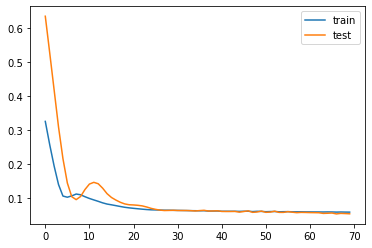

Test MAE:128561.102 
Test RMSE: 157006.753


In [31]:

model = Sequential()
model.add(LSTM(40,activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam=optimizers.Adam(lr=0.001,amsgrad=False)
model.compile(loss='mae', optimizer=adam)
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=15, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,-3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y) 
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae=mean_absolute_error(inv_y, inv_yhat)

print('Test MAE:%.3f '%mae)
print('Test RMSE: %.3f' %rmse)

In [ ]:
import numpy as np
predAll=dataset.tourist*np.nan
predAll[-24:] = inv_yhat
pyplot.figure(figsize=(16,9))
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
pyplot.plot(predAll, label='train')
pyplot.plot(dataset.tourist,label='actual')
pyplot.gca().xaxis.set_major_locator(ticker.MultipleLocator(12))
pyplot.gca().set_xticklabels([0,2012,2013,2014,2015,2016,2017,2018,2019])
pyplot.savefig('one.png')
pyplot.show()

In [ ]:

predAll=dataset.tourist*np.nan
predAll[-24:] = inv_y
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
pyplot.plot(predAll, label='train')
pyplot.plot(dataset.tourist,label='actual')
pyplot.gca().xaxis.set_major_locator(ticker.MultipleLocator(12))
pyplot.gca().set_xticklabels([0,2012,2013,2014,2015,2016,2017,2018,2019])
pyplot.show()

In [ ]:

pyplot.plot(dataset.tourist)
#ticks=ax.set_xticks([0,12,24,36,48,60,72,84])
#labels=ax.set_xticklabels([2012,2013,2014,2015,2016,2017,2018])
pyplot.gca().xaxis.set_major_locator(ticker.MultipleLocator(12))
pyplot.show()
pyplot.close()